In [20]:
from IPython.display import clear_output, Image, display
import PIL.Image
import io
import json
import torch
import numpy as np
from frcnn import Preprocess, SingleImageViz, GeneralizedRCNN, Config, utils
from transformers import LxmertForQuestionAnswering, LxmertTokenizer
import wget
import pickle
import os

IMG_URL = "http://vqa.cloudcv.org/media/test2014/COCO_test2014_000000317987.jpg"
ALT_URL1 = "http://vqa.cloudcv.org/media/test2014/COCO_test2014_000000513313.jpg"
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
GQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/gqa/trainval_label2ans.json"
VQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/vqa/trainval_label2ans.json"
    

# for visualizing output
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [8]:
# load object, attribute, and answer labels
objids = utils.get_data(OBJ_URL)
attrids = utils.get_data(ATTR_URL)
gqa_answers = utils.get_data(GQA_URL)
vqa_answers = utils.get_data(VQA_URL)

In [9]:
# load models and model components
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
frcnn_visualizer = SingleImageViz(IMG_URL, id2obj=objids, id2attr=attrids)
frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

image_preprocess = Preprocess(frcnn_cfg)

lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")
lxmert_gqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-gqa-uncased")
lxmert_vqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-vqa-uncased")

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /home/eltoto/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


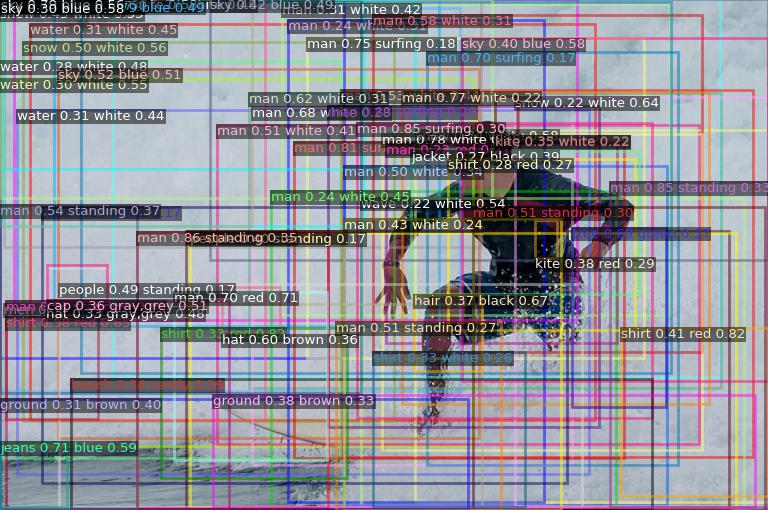

In [21]:
# run frcnn
images, sizes, scales_yx = image_preprocess(ALT_URL1)
output_dict = frcnn(images, sizes, scales_yx=scales_yx)
output_dict = output_dict[0] # we only want the first image
features = output_dict.pop("roi_features")
boxes = output_dict.pop("boxes")
# add boxes and labels to the image
frcnn_visualizer.draw_boxes(
    boxes,
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_scores"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_scores"),
)

showarray(frcnn_visualizer._get_buffer())

In [19]:
Q1 = "What sport is the man playing?"
Q2 = "what is the man riding?"
Q3 = "What is the man wearing?"
test_question = [Q3]
# run lxmert
inputs = lxmert_tokenizer(
    test_question,
    padding="max_length",
    max_length=20,
    truncation=True,
    return_token_type_ids=True,
    return_attention_mask=True,
    add_special_tokens=True,
)

output_gqa = lxmert_gqa(
    input_ids=torch.tensor(inputs.input_ids),
    attention_mask=torch.tensor(inputs.attention_mask),
    visual_feats=features.unsqueeze(0),
    visual_pos=boxes.unsqueeze(0),
    token_type_ids=torch.tensor(inputs.token_type_ids),
    return_dict=True,
    output_attentions=False,
)
output_vqa = lxmert_vqa(
    input_ids=torch.tensor(inputs.input_ids),
    attention_mask=torch.tensor(inputs.attention_mask),
    visual_feats=features.unsqueeze(0),
    visual_pos=boxes.unsqueeze(0),
    token_type_ids=torch.tensor(inputs.token_type_ids),
    return_dict=True,
    output_attentions=False,
)
# get prediction
pred_vqa = output_vqa["question_answering_score"].argmax(-1)
pred_gqa = output_gqa["question_answering_score"].argmax(-1)
print("Question:", test_question)
print("prediction from LXMERT GQA:", gqa_answers[pred_gqa])
print("prediction from LXMERT VQA:", vqa_answers[pred_vqa])

Question: ['What is the man wearing?']
prediction from LXMERT GQA: suit
prediction from LXMERT VQA: wetsuit
